#CIS545 Group Project
Asoluka Emeribe, Eloi Divol, and Gabrielle Bioteau<br>
December 12, 2022

#Motivation
In essence, the goal of this project is to comprehensively explore the link between emotions in song popularity. We will do this through using the nltk library to examine sentiment of songs. We are all interested in Music in general, with over 100k minutes of listening per year each. This project was a way for us to delve into that a bit more seriously. By analyzing a large dataset of popular music in Brazil, we aim to see if there are any trends that differentaite genres, artists, and success in the industry, and if those differences are something we can build into a comprehensive model.

#Imports

In [ ]:
#Importing all relevent libraries
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading data
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!kaggle datasets download -d neisse/scrapped-lyrics-from-6-genres
!unzip scrapped-lyrics-from-6-genres.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 128M/129M [00:03<00:00, 34.1MB/s]
100% 129M/129M [00:03<00:00, 35.0MB/s]
Archive:  scrapped-lyrics-from-6-genres.zip
  inflating: artists-data.csv        
  inflating: lyrics-data.csv         


#Artists Dataset

This dataset contains the name of artists of 4,168 unique artists, the genres that their music falls into, the number of songs they have, and their popularity.

In [ ]:
#create artists dataframe
df_artists = pd.read_csv('artists-data.csv')
df_artists.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


Data cleaning:

We are examining the type of the values as well as checking if there are any null values that need to be droped. There are a few, so we will need to drop them. 

In [ ]:
df_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4168 entries, 0 to 4167
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Artist      4167 non-null   object 
 1   Genres      4163 non-null   object 
 2   Songs       4167 non-null   float64
 3   Popularity  4166 non-null   float64
 4   Link        4167 non-null   object 
dtypes: float64(2), object(3)
memory usage: 162.9+ KB


In [ ]:
#there are a few nulls
display(df_artists.isnull().sum()) 

Artist        1
Genres        5
Songs         1
Popularity    2
Link          1
dtype: int64

In [ ]:
df_artists.dropna(inplace=True)

In [ ]:
df_artists['Genres'].value_counts

<bound method IndexOpsMixin.value_counts of 0                   Pop; Axé; Romântico
1                                   Axé
2                Axé; Romântico; Reggae
3                                   Axé
4                   Pop; Axé; Romântico
                     ...               
4163    World Music; Black Music; Blues
4164                        World Music
4165                        World Music
4166      World Music; Gospel/Religioso
4167      World Music; Gospel/Religioso
Name: Genres, Length: 4162, dtype: object>

#Lyrics Dataset

This dataset contains the name of the 380k distinct songs along with language information and uncleaned lyric data.

In [ ]:
#create lyrics dataframe
df_lyrics = pd.read_csv('lyrics-data.csv')
df_lyrics.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


Data cleaning:

We are examining the type of the values as well as checking if there are any null values that need to be dropped. There are a few, so we will drop them. For this project, we want to analyze songs that are in english, so we will drop rows that are not in english.

In [ ]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379931 entries, 0 to 379930
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ALink     379930 non-null  object
 1   SName     379928 non-null  object
 2   SLink     379930 non-null  object
 3   Lyric     379854 non-null  object
 4   language  365296 non-null  object
dtypes: object(5)
memory usage: 14.5+ MB


In [ ]:
#indicates there are a few nulls
display(df_lyrics.isnull().sum()) 

ALink           1
SName           3
SLink           1
Lyric          77
language    14635
dtype: int64

In [ ]:
df_lyrics.dropna(inplace=True)

In [ ]:
#Filter for english
df_lyrics = df_lyrics[df_lyrics["language"] == "en"]

#Joined Dataset

We want to join the data sets (we join on Link(df_artists) and ALink(df_lyrics)) so that we can correlate fields from df_artists and df_lyrics. We also perfomred cleaning on the Lyric column by taking out newline characters that would not be relevant to our final result and creating a df_exploded that split up the Genres column to distinguish distinct genres.

In [ ]:
#Join datasets
df_joined = pd.merge(df_artists, df_lyrics, left_on='Link', right_on='ALink', how='inner')

#Extra Cleaning
df_joined.drop(columns=["Link", "ALink", "SLink"], inplace=True)
display(df_joined)

,Artist,Genres,Songs,Popularity,SName,Lyric,language
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en
1,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en
2,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en
3,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,Easy,"Know it sounds funny\nBut, I just can't stand ...",en
4,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en
...,...,...,...,...,...,...,...
191371,Johnny Clegg,World Music; Gospel/Religioso,34.0,0.0,The Waiting,Chorus\nHere we stand waiting on the plain\nDa...,en
191372,Johnny Clegg,World Music; Gospel/Religioso,34.0,0.0,Too Early For The Sky,I nearly disappeared into the mouth of a croco...,en
191373,Johnny Clegg,World Music; Gospel/Religioso,34.0,0.0,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i...",en
191374,Johnny Clegg,World Music; Gospel/Religioso,34.0,0.0,When The System Has Fallen,Sweat in the heat for days on end\nwaiting for...,en


In [ ]:
#removing new line characters from the lyrics column
df_joined["Lyric"] = df_joined["Lyric"].apply(lambda x: str(x).replace("\n", " "))
df_joined["Lyric Count"] = df_joined["Lyric"].apply(lambda x: len(x.split()))
display(df_joined)

,Artist,Genres,Songs,Popularity,SName,Lyric,language,Lyric Count
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,Careless Whisper,I feel so unsure As I take your hand and lead ...,en,299
1,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya Or even try to school,...",en,161
2,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here Don't be co...",en,159
3,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,Easy,"Know it sounds funny But, I just can't stand t...",en,175
4,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,For Your Babies (The Voice cover),You've got that look again The one I hoped I h...,en,215
...,...,...,...,...,...,...,...,...
191371,Johnny Clegg,World Music; Gospel/Religioso,34.0,0.0,The Waiting,Chorus Here we stand waiting on the plain Dark...,en,198
191372,Johnny Clegg,World Music; Gospel/Religioso,34.0,0.0,Too Early For The Sky,I nearly disappeared into the mouth of a croco...,en,137
191373,Johnny Clegg,World Music; Gospel/Religioso,34.0,0.0,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i...",en,221
191374,Johnny Clegg,World Music; Gospel/Religioso,34.0,0.0,When The System Has Fallen,Sweat in the heat for days on end waiting for ...,en,260


We created another data frame, df_exploded, where we explode on the Genres column. We do this so that we can access individual genres easily. We want to avoid having to do substring analysis on the genres coulmn

In [ ]:
df_exploded = df_joined
df_exploded['Genres'] = df_exploded['Genres'].apply(lambda x : x.split('; '))
df_exploded.rename(columns={'Genres': 'Genre'}, inplace=True)
df_exploded = df_exploded.explode('Genre')

#EDA

Our Exploratory Data Analysis consisted of us examining a correlation matrix, examining field counts, and plotting different graphs based on interests/hypotheses we had about our data.

We wanted to start by checking if there were any immediate correlations in our data such as number of songs by artist, with popularity or length of the songs

Text(0.5, 1.0, 'Correlation Matric of Joined Df')

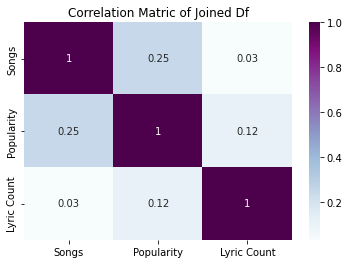

In [ ]:
#We see that no column is highly correlated with another. The higest correlation 
#we see is with songs and popularity
corr_matrix = df_joined.corr()
sns.heatmap(corr_matrix, annot = True, cmap="BuPu")
plt.title('Correlation Matric of Joined Df')

In [ ]:
#find number of genres and explore
df_exploded['Genre'].value_counts()

Rock             63717
Pop              33571
Pop/Rock         26360
Heavy Metal      21758
Hip Hop          20902
                 ...  
Pagode              29
Forró               18
Kizomba              7
Electro Swing        6
Regional             2
Name: Genre, Length: 75, dtype: int64

We see here that some genres are very represented in the charts, whereas other were much more uncommon

This graph shows us that Rock and Pop are heavily represented in our dataset as compared to generes like House and Instrumental.

Text(0, 0.5, 'Occurances')

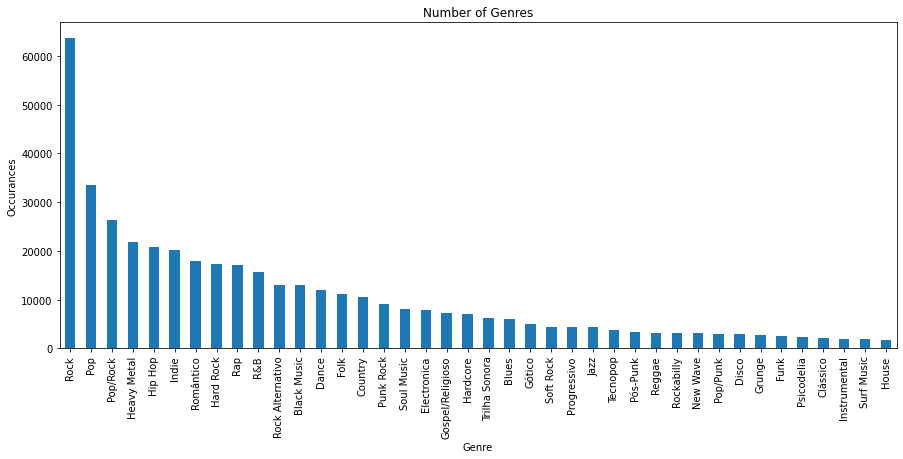

In [ ]:
#Graph of Instances per Genre
df_exploded['Genre'].value_counts()[:40].plot(kind='bar', figsize=(15,6))
plt.title('Number of Genres')
plt.xlabel('Genre')
plt.ylabel('Occurances')


In [ ]:
#number of songs by artist
df_joined['Artist'].value_counts()

Frank Sinatra         819
Elvis Presley         747
Dolly Parton          723
Matheus Hardke        707
Lil Wayne             689
                     ... 
Jeanne Mascarenhas      1
Davi Silva              1
Scandal (j-pop)         1
Roberta Campos          1
Dulce María             1
Name: Artist, Length: 2485, dtype: int64

This graph shows that alot of the most frequently recurring artists in the dataset are older but also well known. In comparing the number of songs per artist with the popularity of artists, we do not see much oberlap. This may be due to the time the popularity was calculated. Newer artsist are among the most popular. If the data was taken a few years ago, there may be more overlap between the num of songs per artist and popularity

Text(0, 0.5, 'Occurances')

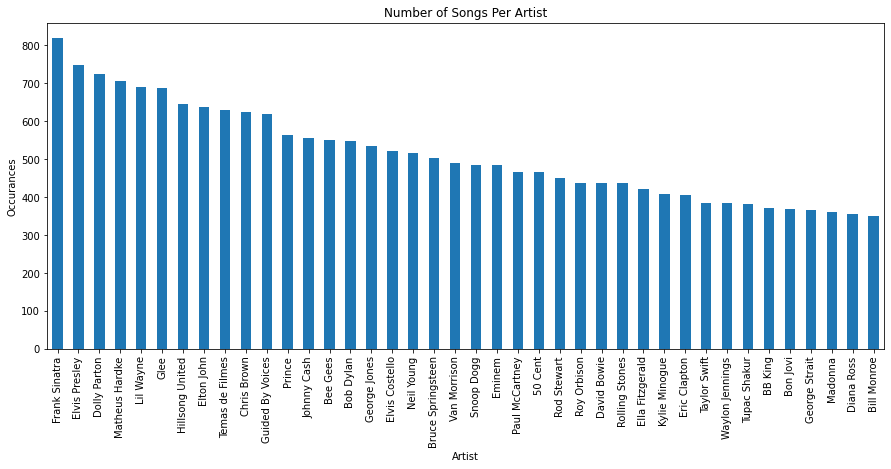

In [ ]:
#Number of Songs Per Artist
df_joined['Artist'].value_counts()[:40].plot(kind='bar', figsize=(15,6))
plt.title('Number of Songs Per Artist')
plt.xlabel('Artist')
plt.ylabel('Occurances')

Text(0, 0.5, 'Popularity')

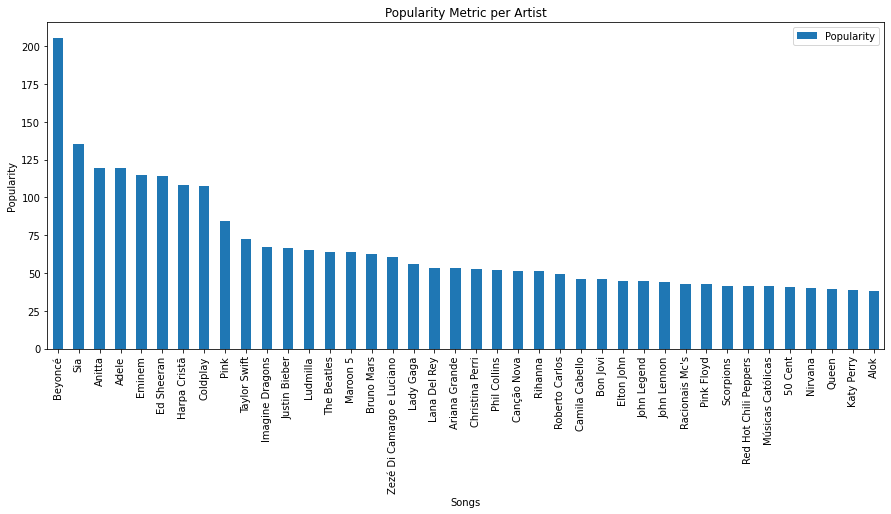

In [ ]:
#Popularity of Artists
df_popularity = df_artists.sort_values(by=['Popularity'], ascending=False)
df_popularity = df_popularity[["Artist", "Popularity"]]
df_popularity[:40].plot(kind='bar', x = 'Artist', y = 'Popularity', figsize=(15,6))
plt.title('Popularity Metric per Artist')
plt.xlabel('Songs')
plt.ylabel('Popularity')

This graph shows us that genres like Rap and Hip Hop have the highest lyric counts amongst genres; we also interestingly found that Lofi music also has high lyric counts, possibly due to the way the sources in which this data was scraped defines lyrics. We then take a look at the lyric count per artist, noting that many with the highest lyric count produce rap and hip hop songs.

Text(0, 0.5, 'Lyric Count')

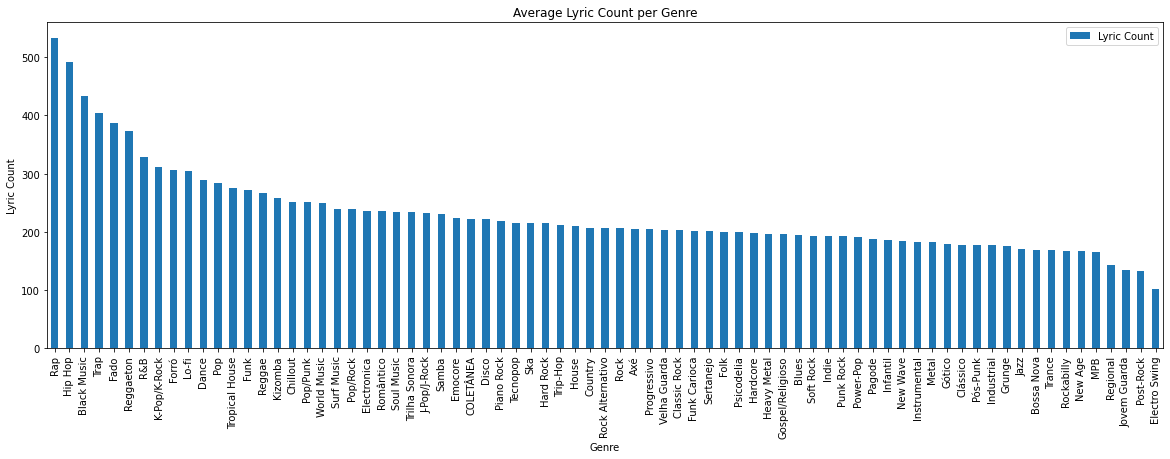

In [ ]:
#average song length and genre
new_df = df_exploded[['Genre','Lyric Count']].groupby('Genre').mean()
new_df = new_df.sort_values(by='Lyric Count', ascending = False).reset_index()
new_df.plot(kind='bar',x='Genre', y='Lyric Count', figsize=(20,6))
plt.title('Average Lyric Count per Genre')
plt.xlabel('Genre')
plt.ylabel('Lyric Count')

Text(0, 0.5, 'Lyric Count')

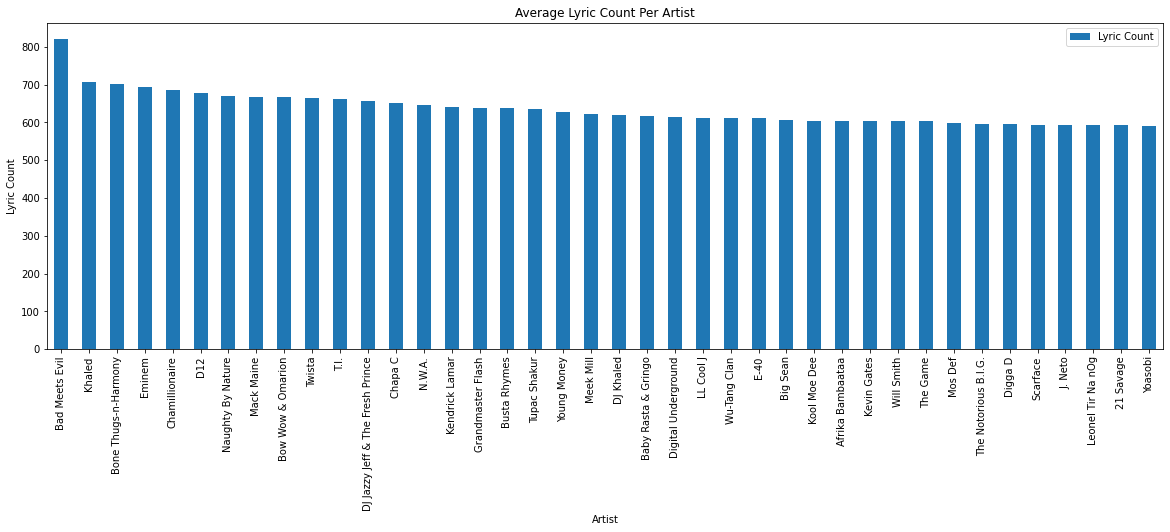

In [ ]:
#average length of song
avg_df = df_joined[["Artist", "Lyric Count"]].groupby("Artist").mean()
avg_df = avg_df.sort_values(by='Lyric Count', ascending=False).reset_index()
avg_df[:40].plot(kind='bar',x='Artist', y='Lyric Count', figsize=(20,6))
plt.title('Average Lyric Count Per Artist')
plt.xlabel('Artist')
plt.ylabel('Lyric Count')

**Sentiment**

We then perform sentiment analysis on the lyrics in the dataset. We first define a function to output sentiment of the lyrics. We then add a coulumn to the dataset with the sentiment score

In [ ]:
#sentiment function
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def retrieve_sentiment(content):
  d = sia.polarity_scores(content)
  return d['compound']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


One issue that we ran into was runtime. We originally planed to preform sentiment analysis on the entire dataframe. Due to the size of the dataframe, the run time took over  1 hour before we decided to terminte the cell. We instead decided to do our modeling and analysis on specifc genres to reduce the run time.

We begin out analysis using genres that we believe are opposing: Jazz and Grunge. We assume that Jazz artists will have a higher sentiment that Grunge artists due to the darker lyrics that are assiocated with Grunge music. 

In [ ]:
#make a sentiment analysis column
nltk.download('punkt')
df_sentiment = df_exploded[(df_exploded["Genre"] == "Jazz") | (df_exploded["Genre"] == "Grunge")]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df_sentiment['Sentiment'] = df_sentiment['Lyric'].apply(lambda x : retrieve_sentiment(x))
display(df_sentiment)

<ipython-input-27-d312bb9b2bf9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment['Sentiment'] = df_sentiment['Lyric'].apply(lambda x : retrieve_sentiment(x))


,Artist,Genre,Songs,Popularity,SName,Lyric,language,Lyric Count,Sentiment
11647,Amy Winehouse,Jazz,70.0,13.5,Back To Black,He left no time to regret Kept his dick wet Wi...,en,196,-0.8225
11648,Amy Winehouse,Jazz,70.0,13.5,Valerie,Well sometimes I go out by myself And I look a...,en,275,0.3313
11649,Amy Winehouse,Jazz,70.0,13.5,Rehab,"They tried to make me go to rehab,but I said, ...",en,307,-0.5864
11650,Amy Winehouse,Jazz,70.0,13.5,You Know I'm No Good,Meet you downstairs in the bar and heard Your ...,en,253,-0.9331
11651,Amy Winehouse,Jazz,70.0,13.5,Tears Dry On Their Own,All I'll can ever be to you Is a darkness that...,en,366,-0.0654
...,...,...,...,...,...,...,...,...,...
189643,A Princesa e O Sapo,Jazz,21.0,1.0,Down In New Orleans,(Introduction) The Evening Star is shining bri...,en,188,0.9517
189644,A Princesa e O Sapo,Jazz,21.0,1.0,Gonna Take You There,We gonna take you there We gonna take you ther...,en,121,0.0000
189645,A Princesa e O Sapo,Jazz,21.0,1.0,Down in New Orleans (Finale),There's a city Way down on the river Where t...,en,75,0.9097
189646,A Princesa e O Sapo,Jazz,21.0,1.0,Friends On The Other Side,Friends On The Other Side Dr. Facilier; Don't...,en,438,0.9958


Our analysis shows that Jazz artists on average have a higher sentiment than Grunge artists. This makes sense given the darker lyrics assiocated with Grunge music. 

<ipython-input-28-77fd10cbbdcb>:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(df.Artist, df.Sentiment)


Text(0, 0.5, 'Sentiment')

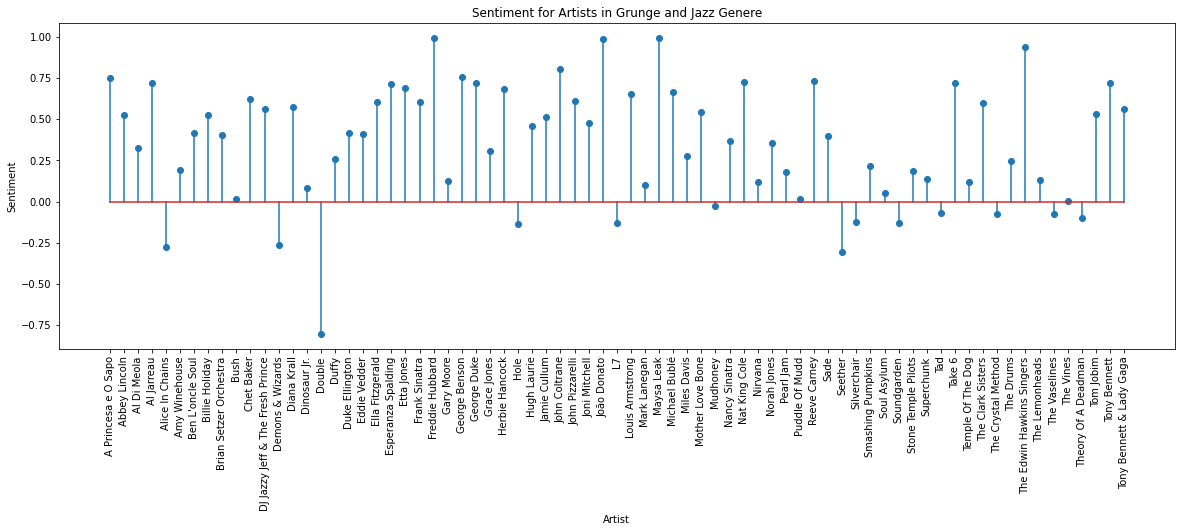

In [ ]:
#average sentiment and popularity
df = df_sentiment.groupby("Artist")['Sentiment'].mean().reset_index()
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.stem(df.Artist, df.Sentiment)
plt.xticks(rotation = 90)

plt.title('Sentiment for Artists in Grunge and Jazz Genere')
plt.xlabel('Artist')
plt.ylabel('Sentiment')

In [ ]:
df_2 = df_sentiment.groupby('Genre').mean().reset_index()
df_2

,Genre,Songs,Popularity,Lyric Count,Sentiment
0,Grunge,137.692951,4.804106,175.373547,0.037973
1,Jazz,302.846650,4.748423,170.901911,0.549392


We then decide to pick genres that we think will be more similar in terms of sentiment: Black Music and Hip Hop.


Text(0.5, 1.0, 'Correlation Matrix: Jazz and Grunge Only')

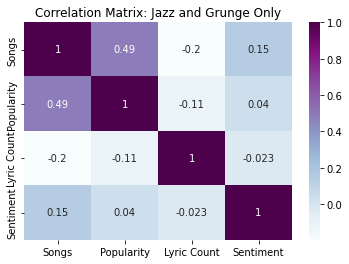

In [ ]:
corr_matrix_sent = df_sentiment.corr()
sns.heatmap(corr_matrix_sent, annot = True, cmap="BuPu")
plt.title('Correlation Matrix: Jazz and Grunge Only')

In [ ]:
df_sentiment2 = df_exploded[(df_exploded["Genre"] == "Hip Hop") | (df_exploded["Genre"] == "Black Music")]

df_sentiment2['Sentiment'] = df_sentiment2['Lyric'].apply(lambda x : retrieve_sentiment(x))
df_sentiment2['Genre'].value_counts()

<ipython-input-31-283f3e4514ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment2['Sentiment'] = df_sentiment2['Lyric'].apply(lambda x : retrieve_sentiment(x))


Hip Hop        20902
Black Music    13024
Name: Genre, dtype: int64

<ipython-input-32-6f325237f877>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(df.Artist, df.Sentiment)


Text(0, 0.5, 'Sentiment')

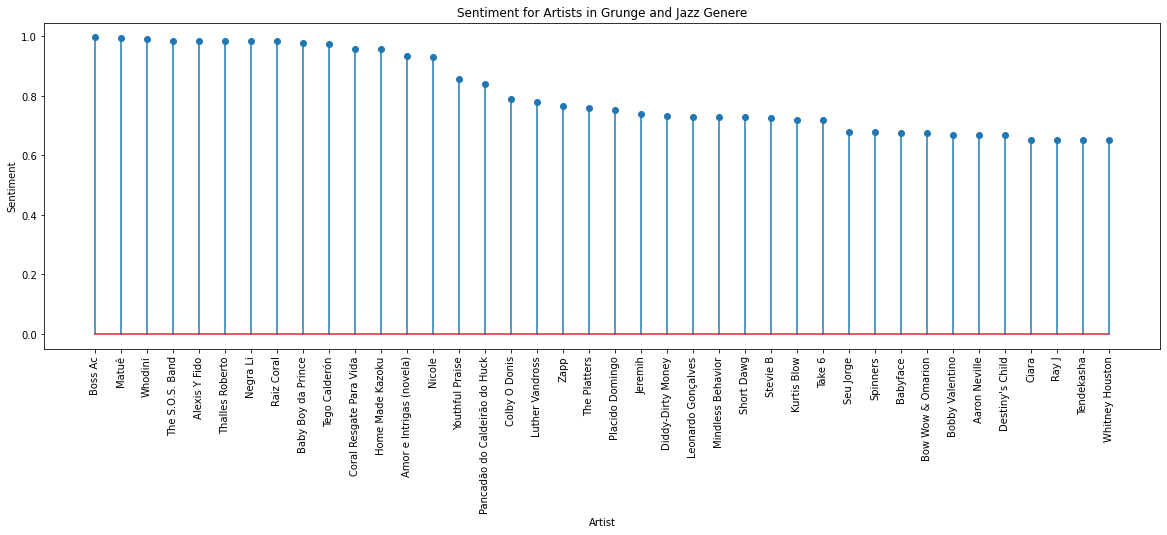

In [ ]:
#average sentiment and popularity - we make two grapgs because there are way more instances than before
df = df_sentiment2.groupby("Artist")['Sentiment'].mean().reset_index()
df = df.sort_values(by=['Sentiment'], ascending=False)
df2 = df.tail(40)
df = df.head(40)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.stem(df.Artist, df.Sentiment)
plt.xticks(rotation = 90)

plt.title('Sentiment for Top Artists in Black Music and Hip Hop Genres')
plt.xlabel('Artist')
plt.ylabel('Sentiment')

We can see from the graph above that there is much more similarity here in terms of sentimentality for both genres, with artists from both showing up in the top 20

<ipython-input-33-83274821b2ea>:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(df2.Artist, df2.Sentiment)


Text(0, 0.5, 'Sentiment')

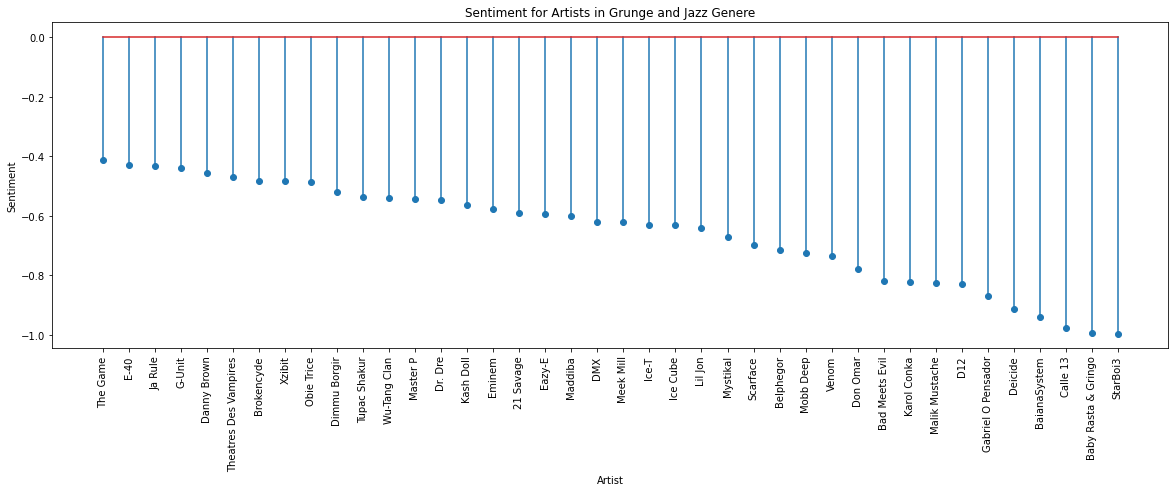

In [ ]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.stem(df2.Artist, df2.Sentiment)
plt.xticks(rotation = 90)

plt.title('Sentiment for Bottom Artists in Black Music and Hip Hop genres')
plt.xlabel('Artist')
plt.ylabel('Sentiment')

Once again, the bottom artists are also representative of both genres, clearly these genres are much more even.


In [ ]:
#sentiment lower for hip hop
df_2 = df_sentiment2.groupby('Genre').mean().reset_index()
df_2

,Genre,Songs,Popularity,Lyric Count,Sentiment
0,Black Music,257.049447,12.254799,433.803440,0.130881
1,Hip Hop,203.871735,6.926840,492.006746,0.031619


Using the mean tool we are able to see that there are some differences between the genres, notbale in popularity, but the sentiment of both is close.

# Modeling
In this section, supervised learning models: Linear Regression, Logistic Regression, Decision Trees, Random Forest, and K Nearest Neighbors. As detialed below, we dicided to use binary classification models because of the structure of the data.

## Linear Regression
We first begin our modeling using linear regression. We aim to predict sentiment based on Genre, Song, Popularity and Lyric Count. 

We first select our x and y values, then preform a test train split with the testing batch being 20% of the data.


In [ ]:
#defining the x and y
df_sentiment['Genre'] = df_sentiment['Genre'].apply(lambda x : 1 if(x == 'Jazz') else 0)
x = df_sentiment[['Genre','Songs','Popularity','Lyric Count']]
y = df_sentiment['Sentiment']

#creating a training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<ipython-input-35-8bc3a32ff0e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment['Genre'] = df_sentiment['Genre'].apply(lambda x : 1 if(x == 'Jazz') else 0)


In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [ ]:
coeff_parameter = pd.DataFrame(model.coef_, x.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
Genre,0.495314
Songs,0.000074
Popularity,0.002592
Lyric Count,-0.000081


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


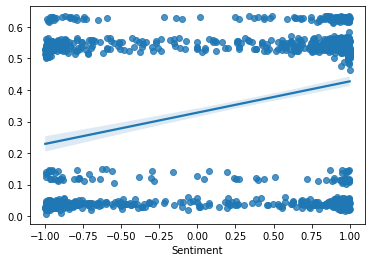

In [ ]:
y_pred = model.predict(x_test)
sns.regplot(y_test,y_pred)

In [ ]:
print(r2_score(y_test, y_pred))

0.10116632435174222


We use the r squared score to measure how well the model fit to the data. As you can see from the low r squared score, simple linear regression does a poor job at predicting the sentiment based on Genre, Songs, Popularity, and Lyric Count.

The graph shows that that the model is not predicting the values of sentiment well.

We instead descide to instead explore binary classification models to predeict if the genre since it is the only binary value in the dataframe.
We also believe that such models will have higher accuarcy than logistic regression. We believe this is the case because Genre has the highest coefficent in the linear regression. Changes in genre have the largest impact on changes in sentiment.

##Logistic Regression
We now move onto using Logistic Regression to predict if a genre is Jazz or Grunge based on Songs, Popularity, Lyric Count, and Sentiment. We use a box plot to visualize the spread of the data, and as we saw previously, Jazz, on average, has higher sentiment. 

We follw the same steps as before: defining what columns will be used as x and y as well as doing a 20-80 test train split before fitting and testing the model.

[Text(0.5, 1.0, 'Boxplot of sentiment of genres')]

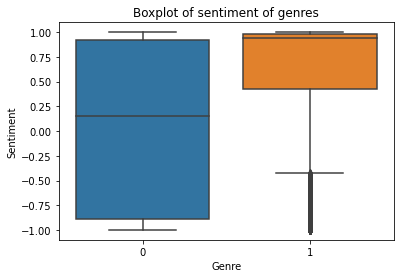

In [ ]:
sns.boxplot(y = 'Sentiment', x = 'Genre', data = df_sentiment).set(title = 'Boxplot of sentiment of genres')

In [ ]:
x_log = df_sentiment[['Songs','Popularity','Lyric Count', 'Sentiment']]
y_log = df_sentiment['Genre']

#creating a training and testing set
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(x_log, y_log, test_size=0.2, random_state=42)

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train_log, y_train_log)
log_pred = logreg.predict(x_test_log)
log_pred = logreg.predict(x_test_log)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test_log, log_pred))

Accuracy: 0.7230443974630021


We use accuay score to asses the preformance of our binary classification models. As we can see, the Linear Regression does a much better job at predicting whether the genre is Jazz or Grunge. However, we want to investiage if we can get a better accuracy score, so we try out a few more powerful models in the next few sections. 

##Decision Trees
We next move on to using ML algorithms. The first being a decision tree classifier.  We follow the same x, y selection and test train split steps.

In [ ]:
x_clf = df_sentiment[['Songs','Popularity','Lyric Count', 'Sentiment']]
y_clf = df_sentiment['Genre']

#creating a training and testing set
x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(x_clf, y_clf, test_size=0.2, random_state=42)

In [ ]:
clf = DecisionTreeClassifier()

clf = clf.fit(x_train_clf,y_train_clf)

y_pred_clf = clf.predict(x_test_clf)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test_clf, y_pred_clf))

Accuracy: 0.959830866807611


Using accuracy score, we see that this more complex model preforms better at predicting genre than logistic regression. Though the model accuracy is very high, we decide to try to tune the hyperparamaters of the model to see if we can get a higher accuracy. After verying the max depth value, we find that increasing it to 15 or above leads to a higher accuarcy. However, increasing the depth of a decision tree leads to overfitting. Since the accuracy is already high, we do not see a benefit of setting a max depth of 15+ to get slighly better accuracy.

In [ ]:
clf2 = DecisionTreeClassifier(criterion="entropy", max_depth=15)

clf2 = clf2.fit(x_train_clf,y_train_clf)

y_pred_clf2 = clf2.predict(x_test_clf)

print("Accuracy:",metrics.accuracy_score(y_test_clf, y_pred_clf2))

Accuracy: 0.9605355884425651


##Random Forest
We then try our next ML algorithm: Random Forests. Because Random Forest uses a "forest" of decision tress, we expect the accuracy to be higher using this algorithm.

In [ ]:
x_rf = df_sentiment[['Songs','Popularity','Lyric Count', 'Sentiment']]
y_rf = df_sentiment['Genre']

#creating a training and testing set
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y_rf, test_size=0.2, random_state=42)

In [ ]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(x_train_rf,y_train_rf)
y_pred=rf.predict(x_test_rf)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test_rf, y_pred))

Accuracy: 0.9718111346018323


We do find that tha accuracy score is slightly higher than the Decision tree defined above. Both models do predict well. However, if we had to choose to use one model over the other, we would opt for the Random Forest classifier. Not only is it more accurate, but it removes the issue of overfitting as discussed in the previous section. 

##K Nearest Neighbors
Lastly, we utalize K nearest neighbors. We can see that the accuarcy is not as high as pervious models used. However, we need to find the best k value to avoid over or under fitting. We notice that as we increase the number of neighbors, the accuarcy does not improve much. Therefore, 3 is the optimal number of neighbors

In [ ]:
x_knn = df_sentiment[['Songs','Popularity','Lyric Count', 'Sentiment']]
y_knn = df_sentiment['Genre']

#creating a training and testing set
x_train_knn, x_test_knn, y_train_knn, y_test_knn = train_test_split(x_knn, y_knn, test_size=0.2, random_state=42)

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train_knn, y_train_knn)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
test_preds = knn_model.predict(x_test_knn)

In [ ]:
print(knn_model.score(x_test_knn, y_test_knn))

0.8992248062015504


#Modeling with Different Genres

##Logistic Regression now with hip hop and black music
In repeating the same steps as above, but now with the genres of hip hop and black music, we assume that these binary classification models will not do as well. We believe that this is the case because the difference between the average sentiment is not as large as with Jazz and Grunge. Black Music and Hip Hop are similar Genres which is why we believe that the sentiment is similar for the two genres.

In [ ]:
#assigning the categorical data to 0 and 1
df_sentiment2['Genre'] = df_sentiment2['Genre'].apply(lambda x : 1 if(x == "Hip Hop") else 0)

<ipython-input-91-06ca4017266b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment2['Genre'] = df_sentiment2['Genre'].apply(lambda x : 1 if(x == "Hip Hop") else 0)


In [ ]:
x_log = df_sentiment2[['Songs','Popularity','Lyric Count', 'Sentiment']]
y_log = df_sentiment2['Genre']
#creating a training and testing set
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(x_log, y_log, test_size=0.2, random_state=42)

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train_log, y_train_log)
log_pred = logreg.predict(x_test_log)
log_pred = logreg.predict(x_test_log)

In [ ]:
#lower than jazz/grunge ig because less difference in sentiment than the other two
print("Accuracy:",metrics.accuracy_score(y_test_log, log_pred))

Accuracy: 0.6374889478337754


As we can see, linear regression does not do as well in predicting the Genre. We believe that the next few models will work better, but not as well as they did in pervious sections. 

##Decision Trees

In [ ]:
x_clf = df_sentiment2[['Songs','Popularity','Lyric Count', 'Sentiment']]
y_clf = df_sentiment2['Genre']

#creating a training and testing set
x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(x_clf, y_clf, test_size=0.2, random_state=42)

In [ ]:
clf = DecisionTreeClassifier()

clf = clf.fit(x_train_clf,y_train_clf)

y_pred_clf = clf.predict(x_test_clf)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test_clf, y_pred_clf))

Accuracy: 0.6024167403477748


Surprisingly, decision trees does not work better than logistic regression. However, the performance is not much worse. Therefore, we expect the random forest to work better than decison tress, but not as well as logistic regression.

##Random Forest

In [ ]:
x_rf = df_sentiment2[['Songs','Popularity','Lyric Count', 'Sentiment']]
y_rf = df_sentiment2['Genre']

#creating a training and testing set
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y_rf, test_size=0.2, random_state=42)

In [ ]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(x_train_rf,y_train_rf)
y_pred=rf.predict(x_test_rf)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test_rf, y_pred))

Accuracy: 0.6052166224580018


The Random Forest classifier hardly has a higher accuracy than decision trees.

##KFold

In [ ]:
x_knn = df_sentiment2[['Songs','Popularity','Lyric Count', 'Sentiment']]
y_knn = df_sentiment2['Genre']

#creating a training and testing set
x_train_knn, x_test_knn, y_train_knn, y_test_knn = train_test_split(x_knn, y_knn, test_size=0.2, random_state=42)

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(x_train_knn, y_train_knn)
test_preds = knn_model.predict(x_test_knn)

In [ ]:
print(knn_model.score(x_test_knn, y_test_knn))

0.5887120542292956


K Nearest Neighbor has the worse performance out of all the models tried above. However, none of the models performed terribly in classifying genre.

#Conclusion

##EDA

We began our EDA by looking at the data set as a whole, observing representation among top songs from the charts in Brazil. We cleaned out non-englis songs and went from there. We observed some clear over representation of genres such as Rock and Roll, and under representation of genres such as Electro Swing. 
We then observed lyric count and sentimentality, and found that genres such as Hip Hop were much heavier on the lyric count than others, which makes sense, but in some cases the differences were much greater than expected. 
We foudn that doing sentiment analysis on all 380k+ songs was not possible given the computational power at our disposal, and so we settled on identifying seemingly different and seemingly similar genres.
Through this we were able to see key differences in lyric count and emotionality, as well as popularity across genres. Given recent musical trends most of the information served to reinforce what we already knew, but som aspects were much more intriguing to us, leading to our Modeling, where we wanted to explore and predictions or more applicable concepts we could make from our observations.

##Modeling
We began our modeling using regression to predict the sentiment of songs. However, we realized that such regression models do not preform well because of the strucutre of our data. However, we would still be able to acomplish the goal of our project by instead using classification models. 

We utilized multiple supervised classification models inclusinf logistic regression, decision tress, random forest, and K nearest neighbors. We evaluated their performance on different genres. We selected genres that we presumed were very different in terms of sentiment then selected two genres that we presumed would be similar in sentiment. 

Afer running and evaluating our models, we found that Random Forest models lead to the highest accuracy. That accuracy was highest for the dataframe that contained Jazz and Grunge. The same was true for the datafame that contained hip hop and Black music, though the accuarcy was not as high as the previous RF model.

We found that the model that preformed the worst our first round of modeling was logistic regression, and the model that performed worst in our second set of modeling was k nearest neighbors. However, in our second set of modeling, there was not as a dramatic difference in model preformance compared to our first set of models. 

In conclusion, one lession we learned is to take time to really think about what models work best on the data you are working with. We jumped straight into linear regression and planned to use other regression models. However, after taking some time to brainstorm, we realized that classification models would make more sense given the data that we are working with.

##Potential Next Steps & Value of Project

There is great value in a project like ours. Studying the correlation between song popularity and emotional messaging is relevant for those interested in whether or not mainstream music truly is positively/negatively affecting the mental health of listeners en masse. Just like how we assumed and demonstrated that average sentiment for a genre like jazz is opposite to grunge (jazz higher, grunge lower), let's assume any one of these genres were one of the most streamed in a given region. Would a popular genre with a negative sentiment result in higher crimes or mental health ailments? Would a popular genre with a positive sentiment result in higher reported citizen happiness or decreased national political tension? These are all theories but the findings from our project, like random forest models leading to high accuracy sentiment predictions, definetely lay a nice groundwork to take such a study to the next level. We envision a great next step to this project would be integrating societal status and general public opinion of a given region with the data we have now to determine how song sentiment and popularity affects a region or culture.